In [66]:
import pandas as pd
import math
import os
import numpy as np
from sklearn import linear_model
from matplotlib import pyplot as plt

In [67]:
games = pd.read_csv(os.path.join("nba", "nba_games_all.csv"))
bets = pd.read_csv(os.path.join("nba", "nba_betting_money_line.csv"))
data = bets.merge(games[["game_id", "team_id", "a_team_id", "is_home", "wl", "season_year"]], 
                  on=["game_id", "team_id", "a_team_id"])
data

,game_id,book_name,book_id,team_id,a_team_id,price1,price2,is_home,wl,season_year
0,41100314,Pinnacle Sports,238,1610612759,1610612760,165.0,-183.0,f,L,2011
1,41100314,5Dimes,19,1610612759,1610612760,165.0,-175.0,f,L,2011
2,41100314,Bookmaker,93,1610612759,1610612760,160.0,-190.0,f,L,2011
3,41100314,BetOnline,1096,1610612759,1610612760,165.0,-190.0,f,L,2011
4,41100314,Bovada,999996,1610612759,1610612760,155.0,-175.0,f,L,2011
...,...,...,...,...,...,...,...,...,...,...
125281,41700215,Heritage,169,1610612755,1610612738,105.0,-125.0,f,L,2017
125282,41700215,Intertops,180,1610612755,1610612738,100.0,-120.0,f,L,2017
125283,41700215,YouWager,139,1610612755,1610612738,105.0,-125.0,f,L,2017
125284,41700215,JustBet,1275,1610612755,1610612738,100.0,-120.0,f,L,2017


In [68]:
indicies = data["book_id"].value_counts().index[:1]
indicies = list(indicies)
indicies

[19]

In [69]:
data = data[data["book_id"].isin(indicies)]
data2 = data[["price2", "wl", "is_home"]]
data = data[["price1", "wl", "is_home"]]
data.rename(columns={'price1': 'moneyline'}, inplace=True)
data2.rename(columns={'price2': 'moneyline'}, inplace=True)
data = data.dropna()
data2 = data2.dropna()

result_mapping1 = {'W': 1, 'L': 0}
result_mapping2 = {'W': 0, 'L': 1}
result_mapping3 = {'f': 0}
result_mapping4 = {'f': 1}
data['wl'] = data['wl'].map(result_mapping1)
data2['wl'] = data2['wl'].map(result_mapping2)
data['is_home'] = data['is_home'].map(result_mapping3)
data2['is_home'] = data2['is_home'].map(result_mapping4)

data = data[data["moneyline"] % 5 == 0]
data2 = data2[data2["moneyline"] % 5 == 0]
data

,moneyline,wl,is_home
1,165.0,0,0
20,190.0,1,0
30,375.0,0,0
40,-280.0,0,0
50,285.0,1,0
...,...,...,...
125227,260.0,1,0
125237,-165.0,0,0
125247,-210.0,0,0
125257,420.0,1,0


In [70]:
data = pd.concat([data, data2], ignore_index=True)
data

,moneyline,wl,is_home
0,165.0,0,0
1,190.0,1,0
2,375.0,0,0
3,-280.0,0,0
4,285.0,1,0
...,...,...,...
26867,-290.0,0,1
26868,155.0,1,1
26869,190.0,1,1
26870,-475.0,0,1


In [71]:
df = data[data["moneyline"] >= -500.0]
df = df[df["moneyline"] <= 500]
len(df)
df

,moneyline,wl,is_home
0,165.0,0,0
1,190.0,1,0
2,375.0,0,0
3,-280.0,0,0
4,285.0,1,0
...,...,...,...
26867,-290.0,0,1
26868,155.0,1,1
26869,190.0,1,1
26870,-475.0,0,1


In [72]:
def decimal_odds(moneyline):
    if moneyline > 0:
        return moneyline / 100 + 1
    else:
        return 100 / -(moneyline) + 1
    
def moneyline_shift(moneyline):
    if moneyline > 0:
        return moneyline - 100
    if moneyline < 0:
        return moneyline + 100
    
def expected_win_prob(moneyline):
    if moneyline < 0:
        return moneyline / (moneyline - 100)
    if value > 0:
        return 1 - moneyline / (moneyline + 100)
    
def num_bets(decimal):
    return math.log(2, decimal)

def expected_value(prob, bets):
    parlay_prob = prob**bets
    expected = parlay_prob - (1-parlay_prob)
    return expected

In [73]:
df["decimal"] = df["moneyline"].apply(decimal_odds)
df["shifted"] = df["moneyline"].apply(moneyline_shift)
df["moneyline"].value_counts()
df = df.groupby('moneyline').filter(lambda x: len(x) >= 10)
df

,moneyline,wl,is_home,decimal,shifted
0,165.0,0,0,2.650000,65.0
1,190.0,1,0,2.900000,90.0
2,375.0,0,0,4.750000,275.0
3,-280.0,0,0,1.357143,-180.0
4,285.0,1,0,3.850000,185.0
...,...,...,...,...,...
26867,-290.0,0,1,1.344828,-190.0
26868,155.0,1,1,2.550000,55.0
26869,190.0,1,1,2.900000,90.0
26870,-475.0,0,1,1.210526,-375.0


In [74]:
model = linear_model.LogisticRegression(C=10)
X = df[["shifted"]]
y = df["wl"]
model.fit(X,y)
model.score(X,y)

0.6637611193062447

In [75]:
model.coef_[0]

array([-0.00517769])

In [76]:
moneylines_neg = np.arange(min(df["moneyline"]), -99, 1)
moneylines_pos = np.arange(100, max(df["moneyline"]) + 1, 1)
moneylines = np.concatenate([moneylines_neg, moneylines_pos])
data = {'moneyline': moneylines}
expected = pd.DataFrame(data)
expected["decimal"] = expected["moneyline"].apply(decimal_odds)
expected["shifted"] = expected["moneyline"].apply(moneyline_shift)
expected["expected_w%"] = expected["moneyline"].apply(expected_win_prob)
expected

,moneyline,decimal,shifted,expected_w%
0,-500.0,1.200000,-400.0,0.833333
1,-499.0,1.200401,-399.0,0.833055
2,-498.0,1.200803,-398.0,0.832776
3,-497.0,1.201207,-397.0,0.832496
4,-496.0,1.201613,-396.0,0.832215
...,...,...,...,...
797,496.0,5.960000,396.0,0.167785
798,497.0,5.970000,397.0,0.167504
799,498.0,5.980000,398.0,0.167224
800,499.0,5.990000,399.0,0.166945


Text(0.5, 1.0, 'Shifted moneyline vs Win Probability')

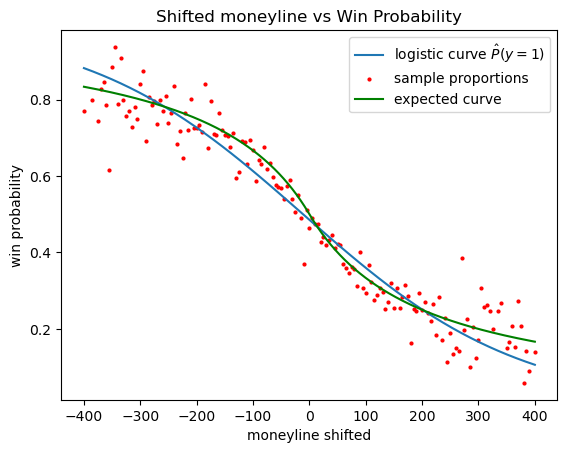

In [77]:
plt.figure()

w = model.coef_[0]
b = model.intercept_
xplot = np.linspace(start=min(df["shifted"]), stop=max(df["shifted"]))
yplot = 1 / (1 + np.exp(-(w * xplot + b)))
plt.plot(xplot, yplot, label=r'logistic curve $\hat{P}(y = 1)$')

x_values, x_counts = np.unique(X, return_counts=True)
n_x_values = x_values.shape[0]
success_props = np.zeros(n_x_values)
for i in np.arange(n_x_values):
    success_props[i] = np.sum(df[df["shifted"] == x_values[i]]["wl"])/x_counts[i]
plt.scatter(x_values, success_props, s = 4, c = "red", label = "sample proportions")

plt.plot(expected["shifted"], expected["expected_w%"], label="expected curve", c = "green")
plt.legend()
plt.xlabel("moneyline shifted")
plt.ylabel("win probability")
plt.title("Shifted moneyline vs Win Probability")

parlayed odds are the decimal odds multiplied by each other

In [78]:
expected["predicted_w_prob"] = model.predict_proba(expected[["shifted"]])[:, 1]

In [79]:
expected

,moneyline,decimal,shifted,expected_w%,predicted_w_prob
0,-500.0,1.200000,-400.0,0.833333,0.882107
1,-499.0,1.200401,-399.0,0.833055,0.881568
2,-498.0,1.200803,-398.0,0.832776,0.881026
3,-497.0,1.201207,-397.0,0.832496,0.880482
4,-496.0,1.201613,-396.0,0.832215,0.879936
...,...,...,...,...,...
797,496.0,5.960000,396.0,0.167785,0.108234
798,497.0,5.970000,397.0,0.167504,0.107736
799,498.0,5.980000,398.0,0.167224,0.107239
800,499.0,5.990000,399.0,0.166945,0.106744


In [80]:
def num_bets(decimal):
    return math.log(2, decimal)
expected["bets"] = expected["decimal"].apply(num_bets)
expected

,moneyline,decimal,shifted,expected_w%,predicted_w_prob,bets
0,-500.0,1.200000,-400.0,0.833333,0.882107,3.801784
1,-499.0,1.200401,-399.0,0.833055,0.881568,3.794833
2,-498.0,1.200803,-398.0,0.832776,0.881026,3.787882
3,-497.0,1.201207,-397.0,0.832496,0.880482,3.780932
4,-496.0,1.201613,-396.0,0.832215,0.879936,3.773981
...,...,...,...,...,...,...
797,496.0,5.960000,396.0,0.167785,0.108234,0.388302
798,497.0,5.970000,397.0,0.167504,0.107736,0.387938
799,498.0,5.980000,398.0,0.167224,0.107239,0.387575
800,499.0,5.990000,399.0,0.166945,0.106744,0.387213


In [83]:
def expected_value(prob, bets):
    parlay_prob = prob**bets
    expected = parlay_prob - (1-parlay_prob)
    return expected
expected["expected_value"] = expected_value(expected["predicted_w_prob"], expected["bets"])
favored = expected[:401]
under = expected[401:]
favored[favored["expected_value"] > 0]

,moneyline,decimal,shifted,expected_w%,predicted_w_prob,bets,expected_value
0,-500.0,1.200000,-400.0,0.833333,0.882107,3.801784,0.241407
1,-499.0,1.200401,-399.0,0.833055,0.881568,3.794833,0.239608
2,-498.0,1.200803,-398.0,0.832776,0.881026,3.787882,0.237810
3,-497.0,1.201207,-397.0,0.832496,0.880482,3.780932,0.236011
4,-496.0,1.201613,-396.0,0.832215,0.879936,3.773981,0.234213
...,...,...,...,...,...,...,...
138,-362.0,1.276243,-262.0,0.783550,0.785501,2.841691,0.007093
139,-361.0,1.277008,-261.0,0.783080,0.784627,2.834725,0.005610
140,-360.0,1.277778,-260.0,0.782609,0.783751,2.827759,0.004133
141,-359.0,1.278552,-259.0,0.782135,0.782872,2.820792,0.002661


In [85]:
expected

,moneyline,decimal,shifted,expected_w%,predicted_w_prob,bets,expected_value
0,-500.0,1.200000,-400.0,0.833333,0.882107,3.801784,0.241407
1,-499.0,1.200401,-399.0,0.833055,0.881568,3.794833,0.239608
2,-498.0,1.200803,-398.0,0.832776,0.881026,3.787882,0.237810
3,-497.0,1.201207,-397.0,0.832496,0.880482,3.780932,0.236011
4,-496.0,1.201613,-396.0,0.832215,0.879936,3.773981,0.234213
...,...,...,...,...,...,...,...
797,496.0,5.960000,396.0,0.167785,0.108234,0.388302,-0.156526
798,497.0,5.970000,397.0,0.167504,0.107736,0.387938,-0.157354
799,498.0,5.980000,398.0,0.167224,0.107239,0.387575,-0.158181
800,499.0,5.990000,399.0,0.166945,0.106744,0.387213,-0.159008


Text(0, 0.5, 'expected value')

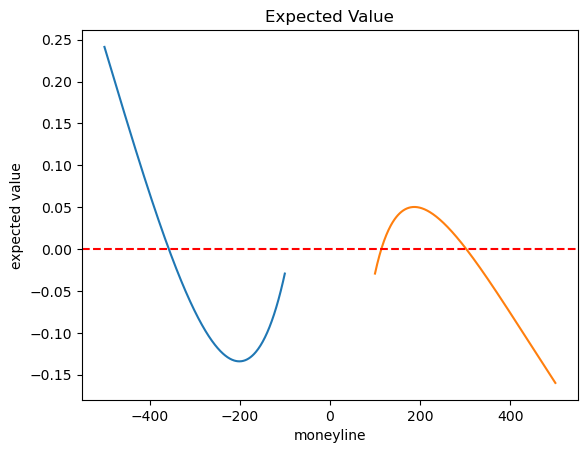

In [86]:
plt.figure()
plt.plot(expected["moneyline"][:401], expected["expected_value"][:401])
plt.plot(expected["moneyline"][401:], expected["expected_value"][401:])
plt.axhline(y = 0, linestyle = "dashed", color = "red")
plt.title("Expected Value")
plt.xlabel("moneyline")
plt.ylabel("expected value")